In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression

from nirs4all.operators.transformations import Gaussian, SavitzkyGolay, StandardNormalVariate, Haar
from nirs4all.pipeline.config import PipelineConfigs
from nirs4all.dataset.dataset_config import DatasetConfigs
from nirs4all.pipeline.runner import PipelineRunner
import json

# pipeline_separated = [
#     MinMaxScaler(feature_range=(0.1, 0.8)),
#     {
#         "feature_augmentation": {
#             "_or_": [Gaussian, StandardNormalVariate, SavitzkyGolay, Haar],
#             "size": [3, (1,2)],
#             "count": 2,
#         }
#     },
#     ShuffleSplit(n_splits=3),
#     {"y_processing": MinMaxScaler},
#     {
#         "model": PLSRegression,
#         "model_params": {
#             "n_components": {
#                 "_range_": [1, 4],
#             }
#         }
#     }
# ]

pipeline = [
    # Normalize the spectra reflectance
    MinMaxScaler(),

    # Generate 10 version of feature augmentation combinations (3 elements with size 1 to 2, ie. [SG, [SNV, GS], Haar])
    {
        "feature_augmentation": {
            "_or_": [
                Gaussian, StandardNormalVariate, SavitzkyGolay, Haar,
            ],
            "size": [3, (1,2)],
            "count": 2,
        }
    },

    # Split the dataset in train and validation
    ShuffleSplit(n_splits=3, test_size=.25),

    # Normalize the y values
    {"y_processing": MinMaxScaler},
]

for i in range(10, 30, 2):
    pipeline.append(PLSRegression(n_components=i))

# create pipeline config
p_config = PipelineConfigs(pipeline)


# path = ['../../sample_data/regression', '../../sample_data/classification', '../../sample_data/binary']
path = '../../sample_data/regression'
d_config = DatasetConfigs(path)

runner = PipelineRunner(save_binaries=False)
results = runner.run(p_config, d_config)
# result = (global_predictions, run_predictions) per dataset

✅ Loaded pipeline(s) with 2 configuration(s).
📥 Loaded 60 predictions from results\regression\regression_predictions.json
🚀 Starting pipeline config_e9107ad7 on dataset regression
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 1: {'class': 'sklearn.preprocessing._data.MinMaxScaler', '_runtime_instance': MinMaxScaler()}
🔹 Executing controller TransformerMixinController with operator MinMaxScaler
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
🔷 Step 2: {'feature_augmentation': [['nirs4all.operators.transformations.signal.Gaussian', 'nirs4all.operators.transformations.nirs.Haar'], ['sklearn.preprocessing._data.StandardScaler', 'nirs4all.operators.transformations.signal.Gaussian']

1. PLSRegression_22 (partition: test_fold_0) - RMSE: 10.563420, R²: 0.830768, MAE: 7.775633
{'prediction_key': 'regression_config_b9b0e736_PLSRegression_11_test_fold_2', 'dataset': 'regression', 'pipeline': 'config_b9b0e736', 'model': 'PLSRegression_11', 'partition': 'test_fold_2', 'sample_count': 33, 'metadata': {'y_processing': 'numeric_MinMaxScaler4', 'model_type': 'PLSRegression_11', 'partition': 'test_fold_2'}, 'fold_idx': 2}
2. PLSRegression_31 (partition: test_fold_0) - RMSE: 11.802081, R²: 0.788753, MAE: 7.982886
{'prediction_key': 'regression_config_b9b0e736_PLSRegression_11_test_fold_2', 'dataset': 'regression', 'pipeline': 'config_b9b0e736', 'model': 'PLSRegression_11', 'partition': 'test_fold_2', 'sample_count': 33, 'metadata': {'y_processing': 'numeric_MinMaxScaler4', 'model_type': 'PLSRegression_11', 'partition': 'test_fold_2'}, 'fold_idx': 2}
3. PLSRegression_49 (partition: test_fold_0) - RMSE: 11.831419, R²: 0.787702, MAE: 8.411660
{'prediction_key': 'regression_config_

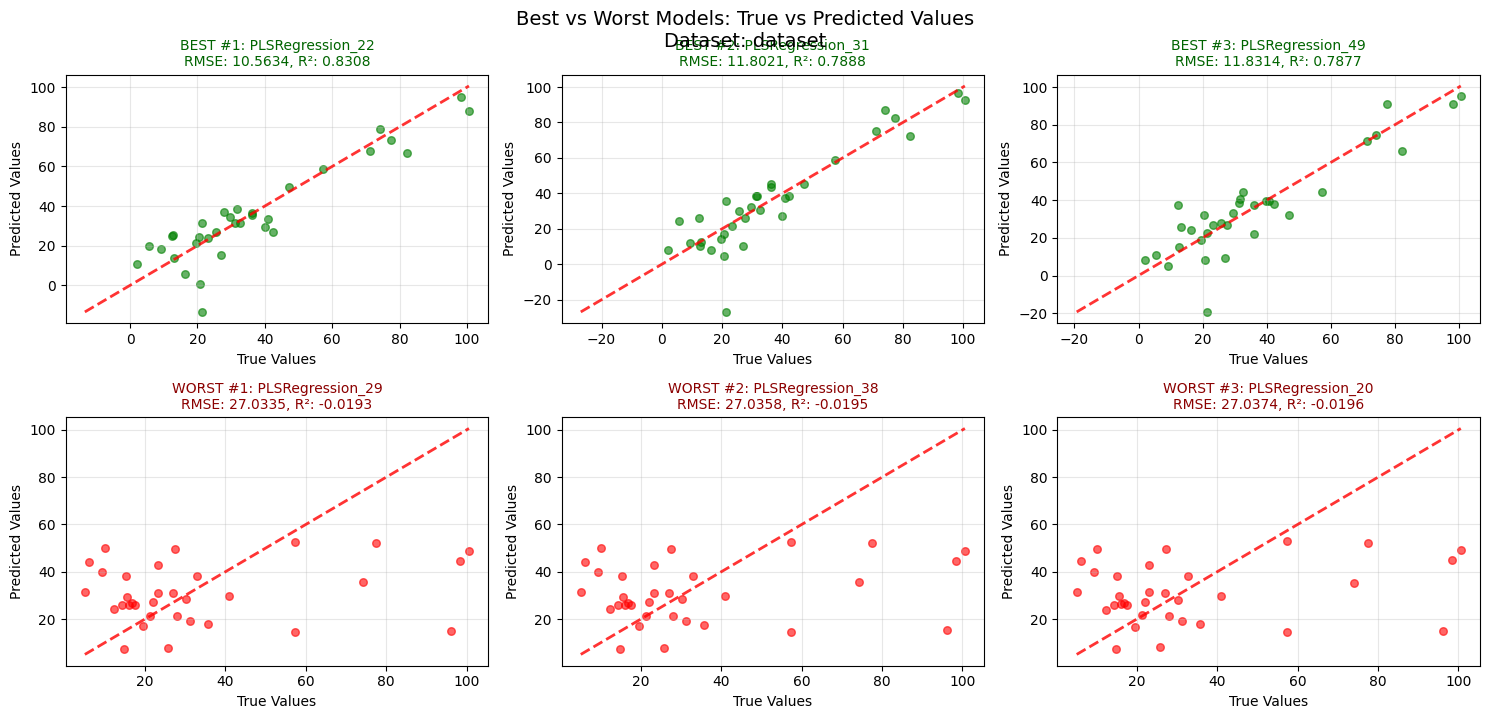

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nirs4all.dataset.prediction_visualizer import PredictionVisualizer

global_predictions, run_predictions = results[0]
visualizer = PredictionVisualizer(global_predictions, dataset_name_override="dataset")

top_5 = visualizer.get_top_k(5, 'rmse')
for i, model in enumerate(top_5, 1):
    print(f"{i}. {model['model']} (partition: {model['partition']}) - RMSE: {model['rmse']:.6f}, R²: {model['r2']:.6f}, MAE: {model['mae']:.6f}")

fig = visualizer.plot_best_worst_models_comparison(
    metric='rmse',
    n_best=3,
    n_worst=3,
    figsize=(15,7)
)
plt.show()

In [13]:
# Create histogram of all scores using simplified helper functions
import numpy as np

# Use the existing visualizer instance
if 'visualizer' not in locals():
    visualizer = PredictionVisualizer(predictions, dataset_name_override="Regression Dataset")

# Create score distribution plots
fig = visualizer.plot_score_distributions(
    metrics=['rmse', 'r2', 'mae', 'mse'],
    bins=20,
    figsize=(15, 10)
)
plt.show()

# Calculate statistics using helper functions
all_evaluations = visualizer.evaluate_predictions()

# Extract metric values for statistics
rmse_values = [eval_rec['rmse'] for eval_rec in all_evaluations]
r2_values = [eval_rec['r2'] for eval_rec in all_evaluations]
mae_values = [eval_rec['mae'] for eval_rec in all_evaluations]
mse_values = [eval_rec['mse'] for eval_rec in all_evaluations]

print(f"\n📊 Score Statistics from {len(all_evaluations)} predictions:")
print(f"RMSE - Mean: {np.mean(rmse_values):.4f}, Std: {np.std(rmse_values):.4f}, Min: {np.min(rmse_values):.4f}, Max: {np.max(rmse_values):.4f}")
print(f"R²   - Mean: {np.mean(r2_values):.4f}, Std: {np.std(r2_values):.4f}, Min: {np.min(r2_values):.4f}, Max: {np.max(r2_values):.4f}")
print(f"MAE  - Mean: {np.mean(mae_values):.4f}, Std: {np.std(mae_values):.4f}, Min: {np.min(mae_values):.4f}, Max: {np.max(mae_values):.4f}")
print(f"MSE  - Mean: {np.mean(mse_values):.4f}, Std: {np.std(mse_values):.4f}, Min: {np.min(mse_values):.4f}, Max: {np.max(mse_values):.4f}")

print("\n✅ Histograms and statistics generated using PredictionVisualizer helper functions")
print("📈 The helper functions simplify evaluation by automatically handling prediction extraction and metric calculation")


📊 Score Statistics from 120 predictions:
RMSE - Mean: 17.8762, Std: 5.0457, Min: 10.5634, Max: 27.0374
R²   - Mean: 0.3406, Std: 0.2794, Min: -0.3671, Max: 0.8308
MAE  - Mean: 13.6276, Std: 3.6441, Min: 7.7756, Max: 20.4425
MSE  - Mean: 345.0177, Std: 203.1908, Min: 111.5858, Max: 731.0187

✅ Histograms and statistics generated using PredictionVisualizer helper functions
📈 The helper functions simplify evaluation by automatically handling prediction extraction and metric calculation
